In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
from tqdm import tqdm


# Homework 10 - Convolutional Neural Networks 2


# Exercise 1

Implement the the layer normalization for the input tensor of shape (batch_size, channels, width, height) - activation map of the convolutional layer

In [2]:
def custom_layer_norm(
    x, gamma: torch.Tensor, beta: torch.Tensor, eps=1e-5
) -> torch.Tensor:
    """
    Custom implementation of layer normalization for 4D tensors.

    Note:
    - Unlike batch normalization which normalizes across batch dimension, not channel dimension
    - For the variance use the unbiased estimator

    :param x: Input tensor of shape (batch_size, channels, height, width)
    :param gamma: Scale parameter
    :param beta: Shift parameter
    :param eps: Small constant for numerical stability
    :returns: Normalized tensor with same shape as input
    """
    # <your_code_here>
    out = None
    # <your_code_here>
    # Output validation
    assert out.shape == x.shape, "Output shape must match input shape"

    return out

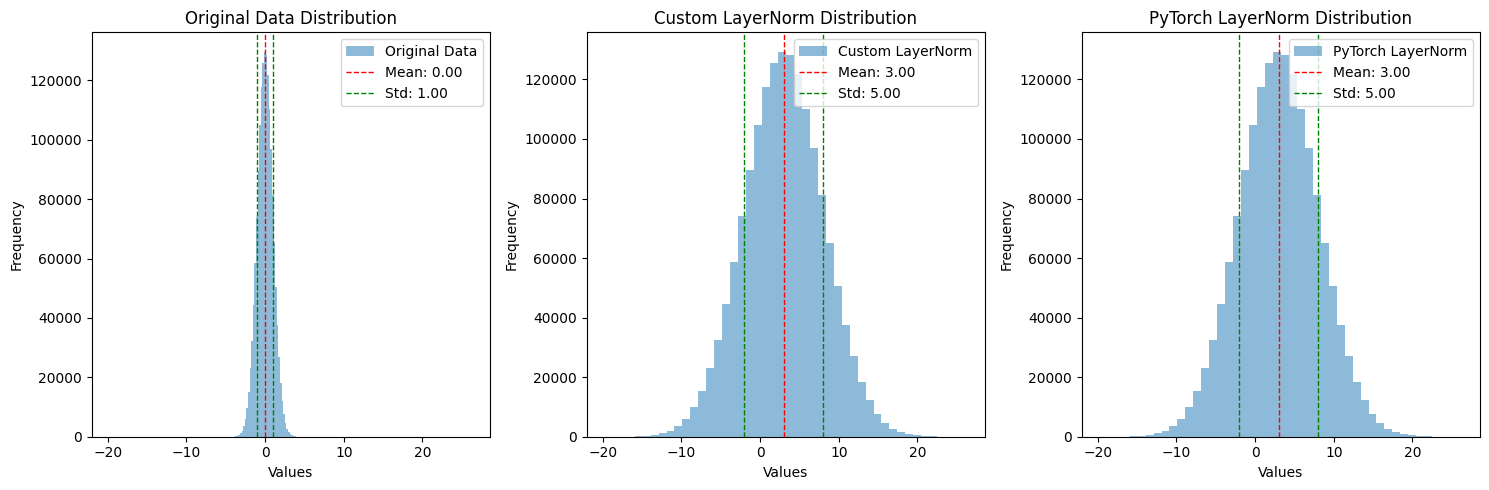

In [3]:
# Create random input tensor
batch_size = 32
channels = 64
height = 28
width = 28
eps = 1e-5
gamma = torch.tensor([5.0] * channels)
beta = torch.tensor([3.0] * channels)

x = torch.randn((batch_size, channels, height, width))

# Apply custom layer norm
custom_out = custom_layer_norm(x, gamma, beta, eps)

# Compare with PyTorch's layer norm
ln = nn.LayerNorm([channels, height, width], eps=eps)
# Broadcast gamma and beta to match the normalized shape
ln.weight.data = gamma.view(-1, 1, 1).expand(channels, height, width)
ln.bias.data = beta.view(-1, 1, 1).expand(channels, height, width)
ln.eval()
torch_out = ln(x)

# Validate output shapes
assert (
    custom_out.shape == torch_out.shape
), "Custom and PyTorch LayerNorm outputs have different shapes"
# Compare statistics
for activation_map_torch, activation_map_custom in zip(torch_out, custom_out):

    assert torch.allclose(
        activation_map_torch, activation_map_custom, atol=1e-5
    ), "Custom and PyTorch LayerNorm outputs have different statistics (mean). Mean difference: {:.6f}".format(
        (activation_map_torch - activation_map_custom).abs().max()
    )
    assert torch.allclose(
        activation_map_torch.std(), activation_map_custom.std(), atol=1e-5
    ), "Custom and PyTorch LayerNorm outputs have different statistics (std). Std difference: {:.6f}".format(
        (activation_map_torch.std() - activation_map_custom.std()).abs().max()
    )

# Plot comparison of distributions
plt.figure(figsize=(15, 5))

# Get overall min and max for x-axis limits
all_data = [
    x.detach().numpy().flatten(),
    custom_out.detach().numpy().flatten(),
    torch_out.detach().numpy().flatten(),
]
x_min = min(data.min() for data in all_data)
x_max = max(data.max() for data in all_data)

# Plot original data distribution
plt.subplot(131)
orig_data = x.detach().numpy().flatten()
plt.hist(orig_data, bins=50, alpha=0.5, label="Original Data")
plt.axvline(orig_data.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {orig_data.mean():.2f}')
plt.axvline(orig_data.mean() + orig_data.std(), color='g', linestyle='dashed', linewidth=1, label=f'Std: {orig_data.std():.2f}')
plt.axvline(orig_data.mean() - orig_data.std(), color='g', linestyle='dashed', linewidth=1)
plt.title("Original Data Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.xlim(x_min, x_max)
plt.legend()

# Plot custom LayerNorm distribution
plt.subplot(132)
custom_data = custom_out.detach().numpy().flatten()
plt.hist(custom_data, bins=50, alpha=0.5, label="Custom LayerNorm")
plt.axvline(custom_data.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {custom_data.mean():.2f}')
plt.axvline(custom_data.mean() + custom_data.std(), color='g', linestyle='dashed', linewidth=1, label=f'Std: {custom_data.std():.2f}')
plt.axvline(custom_data.mean() - custom_data.std(), color='g', linestyle='dashed', linewidth=1)
plt.title("Custom LayerNorm Distribution")
plt.xlim(x_min, x_max)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()

# Plot PyTorch LayerNorm distribution
plt.subplot(133)
torch_data = torch_out.detach().numpy().flatten()
plt.hist(torch_data, bins=50, alpha=0.5, label="PyTorch LayerNorm")
plt.axvline(torch_data.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {torch_data.mean():.2f}')
plt.axvline(torch_data.mean() + torch_data.std(), color='g', linestyle='dashed', linewidth=1, label=f'Std: {torch_data.std():.2f}')
plt.axvline(torch_data.mean() - torch_data.std(), color='g', linestyle='dashed', linewidth=1)
plt.title("PyTorch LayerNorm Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.xlim(x_min, x_max)
plt.legend()

plt.tight_layout()
plt.show()

# Exercise 2

The goal of this exercise is to implement the custom ResNet block and insert it into the ResNet18 model. Then,
we will fine-tune the model on the CIFAR-10 dataset.

This task will be quite open-ended, so feel free to play around with the implementation.
I want you to a) get the model to work b) get the model to fine-tune on the CIFAR-10 dataset. c) comment on the shape of the training and validation curves

Note the argument `reduce_dataset_by` in the `train_model` function. This is used to reduce the size of the dataset to speed up the training. Feel free to use it (or not) to fit your computational resources.
Same thing for the `num_epochs` argument. If it makes sense to train the model for more (or fewer) epochs, feel free to do so.

In [4]:
class CustomResNetBlock(nn.Module):
    """
    Custom residual block with batch normalization and dropout.

    The implementation should look like this:

    ```
      x ---> ... (residual connection)
      |
     conv1
      |
     batchnorm1
      |
     relu
      |
     dropout
      |
     conv2
      |
     batchnorm2
      |
      + <--- ... (residual connection)
      |
     relu
      |
     out


    Regarding the arguments to the constructor, I'd not change stride, kernel_size, padding.
    Feel free to play with them, but the default values should be good enough and not give you any issues.
    ```

    :param in_channels: number of input channels
    :param out_channels: number of output channels
    :param stride: stride value for convolutions
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        dropout_rate: float,
        stride=1,
        kernel_size=3,
        padding=1,
    ):
        super().__init__()

        # <your_code_here>
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=kernel_size, padding=padding
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        # </your_code_here>

        """
        I added an auxiliary method to flexibly handle the skip connection, just to make
        sure that the dimensions are the same.
        Example usage (in the forward method):
        ```
        ...
        out = F(x)
        out += self.shortcut(x)
        ...
        ```
        """
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # <your_code_here>
        out = None
        # </your_code_here>
        return out


In [5]:
class FineTunedResNet(nn.Module):
    """
    Implements a pretrained ResNet18 model with custom bottom layers.
    The goal is to fine-tune the model on the CIFAR-10 dataset.

    This implementation should:
    1. Load the pretrained ResNet18 model: torchvision.models.resnet18(pretrained=True)
    2. Remove the last 3 last layers
        -Linear
        -AdaptiveAvgPool2d
        -two ResNet blocks (they are practically one layer, see `list(resnet.children()[-3:]))
    3. Freeze all the layers of the altered ResNet18 (so we don't train them, only use them as feature extractors)
    4. Add custom two ResNet blocks to the model
    5. Finally add:
        - AdaptiveAvgPool2d
        - Dropout
        - Linear
    6. Fine-tune the model on the CIFAR-10 dataset (implemented in the `train_model` function)

    The implementation should look like this:

    ```
    x --> ResNet18 (frozen, without last 3 layers) -->
      --> CustomResNetBlock1 (64 filters) -->
      --> CustomResNetBlock2 (32 filters) -->
      --> AdaptiveAvgPool2d
      --> Dropout
      --> Linear
    ```

    Note:
    - The number of filters in the custom ResNet blocks should be reduced to 64 and 32 respectively.
      This is purely for the sake of running the code faster, this is not a good practice! :)
      Ideally this should be done with larger number of filters, e.g. 128 and 64. Note that in
      the original ResNet18 architecture, the number of filters is 512 and 512 respectively.
    - Feel free the setup the dropout rate to your liking

    :param num_classes: number of output classes
    :param pretrained: whether to use pretrained weights
    """

    def __init__(
        self, num_classes: int, pretrained: bool = True, dropout_rate: float = 0.5
    ):
        super().__init__()

        # <your_code_here>
        # </your_code_here>

    def forward(self, x):
        # <your_code_here>
        # </your_code_here>
        return x

In [6]:
def train_model(num_epochs=1, batch_size=64, reduce_dataset_by: int = 1):
    """
    Complete training loop for the fine-tuned model using CIFAR-10 dataset.

    :param num_epochs: number of training epochs
    :param batch_size: size of training batch
    :returns: trained model and training history
    """
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load and normalize CIFAR-10 dataset
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(224),  # ResNet expects 224x224 images
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )
    # Use only half of the training data
    trainset = torch.utils.data.Subset(
        trainset, range(0, len(trainset), reduce_dataset_by)
    )  # Take every other example
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    testset = torch.utils.data.Subset(
        testset, range(0, len(testset), reduce_dataset_by)
    )  # Take every other example
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    # Create model and move to device
    model = FineTunedResNet(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
    )

    # Training history
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} of {num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for i, (images, labels) in enumerate(tqdm(trainloader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{i + 1}/{len(trainloader)}], "
                    f"Loss: {loss.item():.4f}"
                )

        # Calculate training metrics
        train_loss = running_loss / len(trainloader)
        train_acc = 100.0 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(testloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Calculate validation metrics
        val_loss = val_loss / len(testloader)
        val_acc = 100.0 * correct / total

        # Save metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

    return model, history

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified


/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 of 5


100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch [1/5] - Train Loss: 2.0553, Train Acc: 26.56%, Val Loss: 1.9529, Val Acc: 33.20%
Epoch 2 of 5


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


Epoch [2/5] - Train Loss: 1.6679, Train Acc: 42.56%, Val Loss: 1.5895, Val Acc: 49.60%
Epoch 3 of 5


100%|██████████| 4/4 [00:16<00:00,  4.25s/it]


Epoch [3/5] - Train Loss: 1.4788, Train Acc: 52.32%, Val Loss: 1.4161, Val Acc: 50.80%
Epoch 4 of 5


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


Epoch [4/5] - Train Loss: 1.3148, Train Acc: 57.60%, Val Loss: 1.2899, Val Acc: 60.00%
Epoch 5 of 5


100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch [5/5] - Train Loss: 1.2030, Train Acc: 63.68%, Val Loss: 1.2121, Val Acc: 59.60%


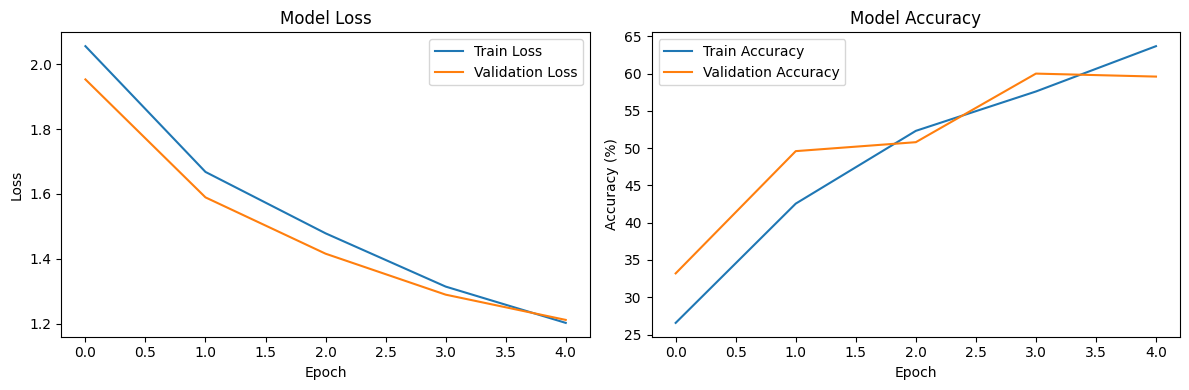

In [7]:
    # `reduce_dataset_by` is used to reduce the size of the dataset to speed up the training.
    # if you set it to 1, the model will be trained on the full dataset.
    # if you set it to 40, the model will be trained on 1/40 of the dataset.
    # if you set it to 100, the model will be trained on 1/100 of the dataset.
    # etc.
    reduce_dataset_by = 40
    num_epochs = 5
    model, history = train_model(num_epochs=num_epochs, reduce_dataset_by=reduce_dataset_by)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Comment on the shape of the training and validation curves: